# CS 670 Final Project: Steam Data Analysis
## Eric Zander

---

## Index

1. [Dataset](#dataset)
2. [Questions](#questions)
3. [Setup](#setup)
4. [Image Feature Extraction](#image-feature-extraction)
5. [Tags](#tags)
6. [Titles and Descriptions](#titles-and-descriptions)
7. [Game Metadata](#game-metadata)
8. [Concurrent Users](#concurrent-users)
9. [Review Scores](#review-scores)
10. [Discussion](#discussion)

---

## Dataset

[Dataset GitHub Repo](https://github.com/NewbieIndieGameDev/steam-insights)

### Description

This dataset contains tables as CSV files describing video game data such as category, descriptions, game details, genres, promotional materials, reviews, tags, and other metadata for 140,082 games. These were sourced from the official [Steamworks Web APIs](https://partner.steamgames.com/doc/webapi) in Octobor 2024.

Additionally, some data concerning predicted ownership, number of concurrent users, and more were sourced from the [SteamSpy](https://steamspy.com/) API.

The data was reportedly collected for EDA and to explore patterns and opportunities in the game development space.

### Discussion

This data has a rich variety of data; promotional images, some textual metadata and reviews, release dates, prices, and more. However, there are some significant limitations as well. The numbers from the SteamSpy API in particular are predictive and some of the most interesting metrics (like number of owners and concurrent users) are imprecise. Also, this dataset being a snapshot from October 2024 limits the ability to answer many questions related to changes over time.

### Summary

The dataset is comprised of the following CSV files. Games are joined on universal "app_id" identifiers.

* **categories.csv**: Misc. textual description tags (ex. multiplayer, family sharing)
* **descriptions.csv**: Textual game descriptions from Steam pages.
* **games.csv**: Metadata about the game such as title, release date and price.
* **genres.csv**: One or more genres per game.
* **promotional.csv**: Links to promotional material like screenshots and videos.
* **reviews.csv**: Aggregations of user and critical review metrics. Textual critic reviews are included for some games.
* **steamspy_insights.csv**: Various metrics sourcedd from the SteamSpy API.
* **tags.csv**: Textual tags describing games. More specific than genre but less technical than categories.

### Limitations

Several steps were taken to further collect, clean, and wrangle the data outside of this notebook.

Some genres were listed in different languages and had to be translated. This was limited enough to be reasonably done with a mapping data structure.

Additionally, some prices had to be converted to one currency. The majority of games were listed in Euros and many more were in USD, GBP, or RUB; the latter were converted to the former and others were dropped during modeling with prices due to the risks posed by errors propogated by inaccurate exchange rates along with the relative infrequency and obscurity of games listed with different currencies. However, it should be noted that this choice may introduce bias related to such games.

Some image feature extraction and text embedding work is done with game header images and game titles/descriptions. To limit the downloading and processing of over 100,000 games, only those predicted to have 10 or more concurrent users were processed in this manner. This leaves 6,174 games and limits the image and text embedding exploration to observing patterns in only more recently relevant games!

Finally, another limitation to note is the lack of review score data for games without sufficient reviews; only those with 10 or more may be included in the predictions near the end.

---

## Questions

* How do user and critic reviews relate to ownership?
* Have prices shifted over the years?
* Header Images
    * What patterns may be observed promotional images?
    * How do image features relate to other features (ex. tags, genres)?
* Tags
    * What tags co-occur?
    * How do tags relate to metrics of success like concurrent users and reviews?
* Success Metrics
    * What factors seem to have a relationship with the number of concurrent users?
    * What factors affect review scores?

---

## Setup

***Imports***

In [253]:
from collections import Counter
from itertools import combinations
import re

######################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from sklearn.cluster import MiniBatchKMeans
from scipy.spatial import cKDTree
from joblib import Parallel, delayed

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from scipy.stats import linregress, pearsonr, spearmanr

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

from sentence_transformers import SentenceTransformer

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

from sklearn.cross_decomposition import CCA

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression, VarianceThreshold
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
import shap

***Load Tabular Data***

In [2]:
data_dir = "../data/oct24_clean/"

top_ids = pd.read_csv(data_dir + "ge-10_concurrent-users.csv")

games = pd.read_csv(data_dir + "games.csv")
desc = pd.read_csv(data_dir + "descriptions.csv")
genres = pd.read_csv(data_dir + "genres_translated.csv")
spy = pd.read_csv(data_dir + "steamspy_insights.csv") 
prom = pd.read_csv(data_dir + "promotional.csv")
tags = pd.read_csv(data_dir + "tags.csv")
reviews = pd.read_csv(data_dir + "reviews.csv")

----

## Image Feature Extraction

> Several features will be extracted for various explorations in the following sections. These include dominant colors via K-Means quantization, color histograms, proportions of signalling colors (ex. red, orange, yellow), and structural features with PCA.

### Load Images

In [3]:
class FeatureData:
    def __init__(self, keys):
        self.data = {}
        self.map = {key: i for i, key in enumerate(keys)}

    def add_column(self, column_name, values):
        self.data[column_name] = values

    def get_column(self, column_name):
        if column_name not in self.data:
            raise KeyError(f"Column '{column_name}' not found.")
        return self.data[column_name]
    
    def __getitem__(self, column_name):
        return self.get_column(column_name)

    def get(self, col, id):
        key = self.map[id]
        return self.get_column(col)[self.map[id]]

    def __repr__(self):
        return f"{self.__class__.__name__}({self.data})"

In [4]:
def load_image(image_path):
    image = cv2.imread(image_path)  # Loads image in BGR format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    return image

image_dir = "../data/img/header"

images = FeatureData(top_ids.app_id)

img = []
for app_id, idx in images.map.items():
    img.append(load_image(f"{image_dir}/{app_id}.jpg"))

images.add_column("img", img)

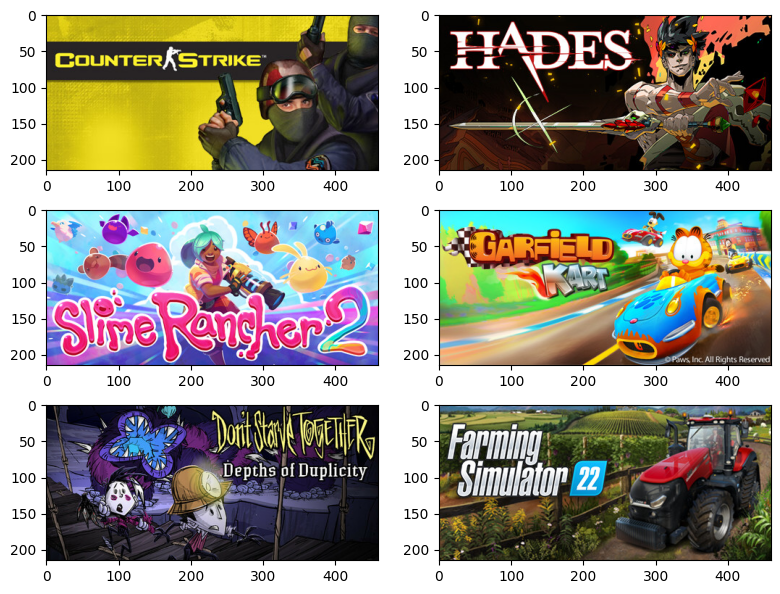

In [5]:
def show_images(imgs):
    fig, axes = plt.subplots(3, 2, figsize=(8, 6))
    for i, ax in enumerate(axes.reshape(-1)):
        ax.imshow(imgs[i])
    plt.tight_layout()

example_ids = [10, 1145360, 1657630, 362930, 322330, 1248130]

# example_ids = np.random.choice(df.app_id, size=(6,))
show_images([images.get("img", id) for id in example_ids])

### Dominant Colors (K-Means Quantization)

In [6]:
def find_top_colors(image_array, k):
    """Find k dominant colors using MiniBatchKMeans for speed."""
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=3, batch_size=1000)  
    kmeans.fit(image_array)
    return kmeans.cluster_centers_

def replace_colors(image_array, top_colors):
    """Replace each pixel with the closest top color using cKDTree."""
    tree = cKDTree(top_colors)
    _, indices = tree.query(image_array)  # Find closest colors
    return top_colors[indices]

def rgb_to_lab(image_array):
    """Convert RGB image to LAB color space for better clustering."""
    return cv2.cvtColor(image_array.astype(np.uint8), cv2.COLOR_RGB2LAB).reshape(-1, 3)

def process_image(img, k):
    """Pipeline for a single image."""
    flat_lab = rgb_to_lab(img)
    top_colors = find_top_colors(flat_lab, k)
    return top_colors

In [7]:
# Process images in parallel
k = 8
knn_colors = Parallel(n_jobs=-1, backend="loky")(
    delayed(process_image)(img, k) for img in images["img"])

images.add_column("knn", np.array(knn_colors))

Quantization: k=8


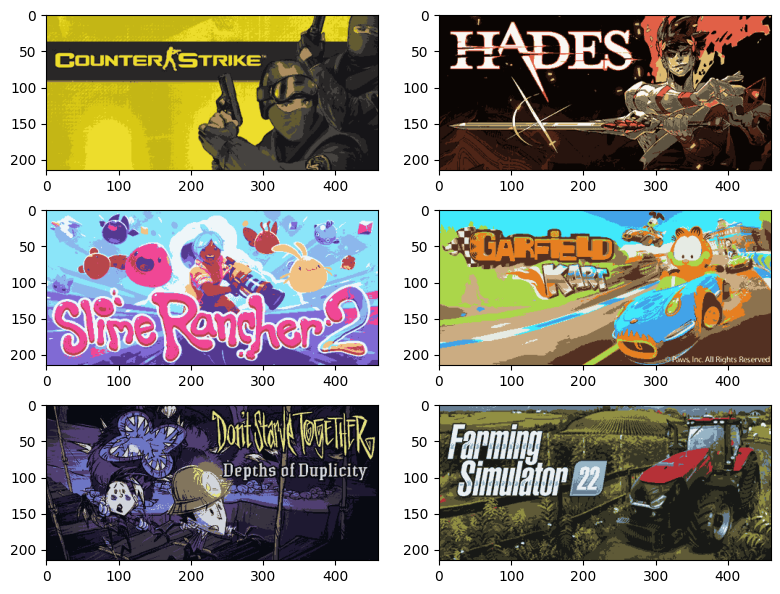

In [8]:
knn_images = []

for img_idx in example_ids:
    img = images.get("img", img_idx)

    flat_lab = rgb_to_lab(img).reshape(-1, 3)
    top_colors = images.get("knn", img_idx)

    knn_image = replace_colors(flat_lab, top_colors)
    knn_image = knn_image.reshape(img.shape).astype(np.uint8)
    knn_image = cv2.cvtColor(knn_image, cv2.COLOR_LAB2RGB) # Back to RGB

    knn_images.append(knn_image)

print(f"Quantization: k={k}")
show_images(knn_images)

### Color Distribution (Histogram Analysis)

In [9]:
# Compute color histograms for all images in the dataset
color_histograms = [[] for _ in range(3)]

for img in images["img"]:
    # Split channels
    r_hist = cv2.calcHist([img], [2], None, [256], [0, 256]).flatten()
    g_hist = cv2.calcHist([img], [1], None, [256], [0, 256]).flatten()
    b_hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
    
    # Normalize histograms (optional)
    r_hist /= r_hist.sum()
    g_hist /= g_hist.sum()
    b_hist /= b_hist.sum()
    
    # Store data
    color_histograms[0].append(r_hist)
    color_histograms[1].append(g_hist)
    color_histograms[2].append(b_hist)

# Convert lists to NumPy arrays
for i in range(3):
    color_histograms[i] = np.array(color_histograms[i])
color_histograms = np.array(color_histograms)
color_histograms = np.transpose(color_histograms, axes=[1, 0, 2])

images.add_column("hist", color_histograms)

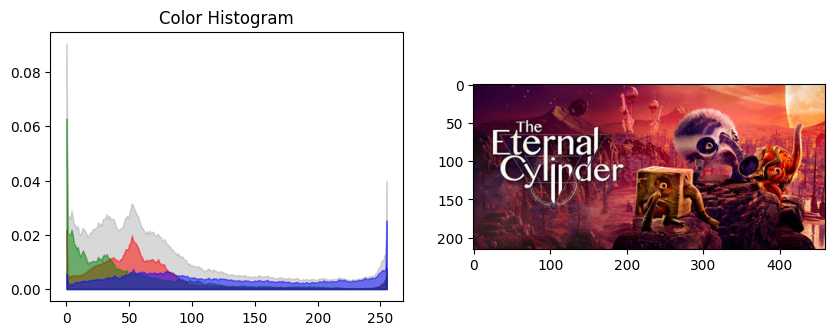

In [10]:
img_idx = 2

y = color_histograms[img_idx]
x = np.arange(y.shape[1])
y_tot = y.sum(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].fill_between(x, y_tot, color="gray", alpha=0.3, label="Total")
axes[0].fill_between(x, y[0], color="red", alpha=0.5, label="R")
axes[0].fill_between(x, y[1], color="green", alpha=0.5, label="G")
axes[0].fill_between(x, y[2], color="blue", alpha=0.5, label="B")
axes[0].set_title("Color Histogram")

axes[1].imshow(images["img"][img_idx])

plt.show()

### Structural Features (PCA)

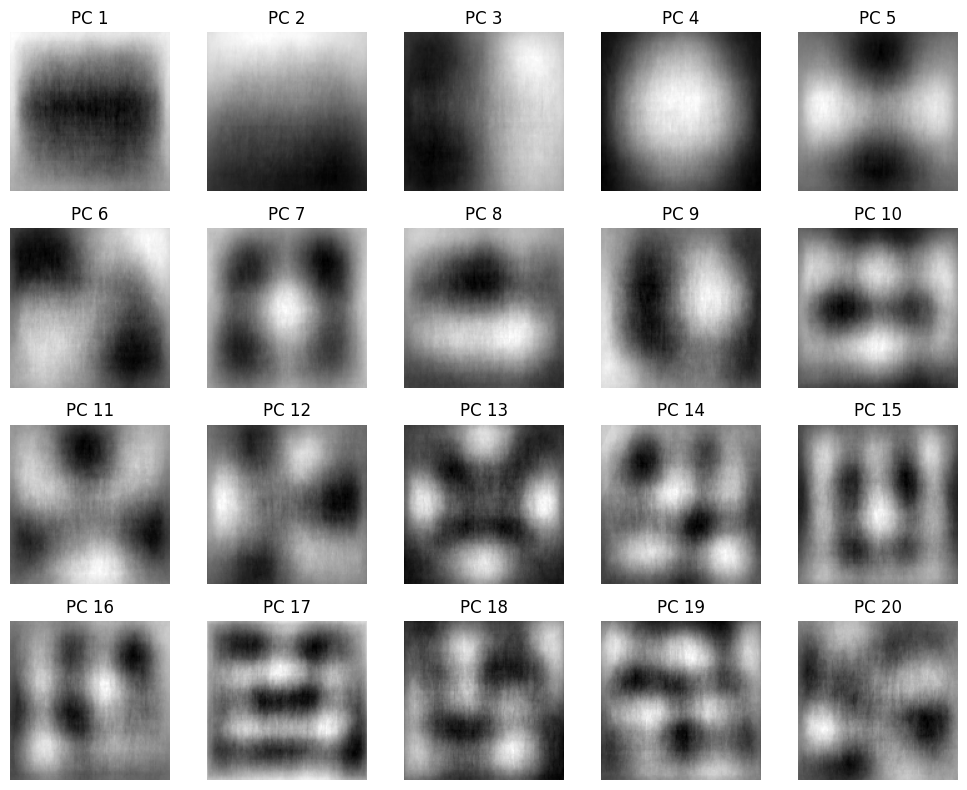

In [11]:
EIG_SIZE = (128, 128)
EIG_COMPONENTS = 20

# Convert images to grayscale and flatten
eig = []

for img in images["img"]:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized = cv2.resize(gray, EIG_SIZE)          # Resize to fixed size
    flattened = resized.flatten()                 # Flatten into 1D vector
    eig.append(flattened)

# Stack all images into a matrix (each row is an image)
image_matrix = np.stack(eig)

# Apply PCA
pca = PCA(n_components=EIG_COMPONENTS)
pca.fit(image_matrix)

# Visualize the top principal components
fig, axes = plt.subplots(EIG_COMPONENTS // 5, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    if i >= EIG_COMPONENTS:
        break
    eigenimage = pca.components_[i].reshape(EIG_SIZE)  # Reshape back to image
    ax.imshow(eigenimage, cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Project images onto principal components
pca_features = pca.transform(image_matrix)

images.add_column("pca", pca_features)

### Signalling Colors

In [12]:
def extract_signaling_color_proportion(color_histograms):
    """Extract proportion of signaling colors (bright red, yellow, orange) from histograms."""
    signaling_proportions = []

    for hist in color_histograms:
        red_hist, green_hist, blue_hist = hist  # Each image's RGB histograms

        # Define bright red & yellow regions in RGB histograms (sums are # of pixels in that range for that histogram)
        bright_red = np.sum(red_hist[200:256]) - np.sum(green_hist[200:256]) - np.sum(blue_hist[200:256])
        bright_yellow = np.sum(red_hist[200:256]) + np.sum(green_hist[200:256]) - np.sum(blue_hist[200:256])
        bright_orange = np.sum(red_hist[180:220]) + np.sum(green_hist[100:180]) - np.sum(blue_hist[0:100])

        # Normalize by total pixels to get proportion
        total_pixels = np.sum(red_hist) + np.sum(green_hist) + np.sum(blue_hist)
        signaling_score = (bright_red + bright_yellow + bright_orange) / total_pixels

        signaling_proportions.append(max(0, signaling_score))  # Ensure non-negative values

    return np.array(signaling_proportions)

# Extract signaling color proportions
signaling_scores = extract_signaling_color_proportion(color_histograms)

images.add_column("signal", signaling_scores)

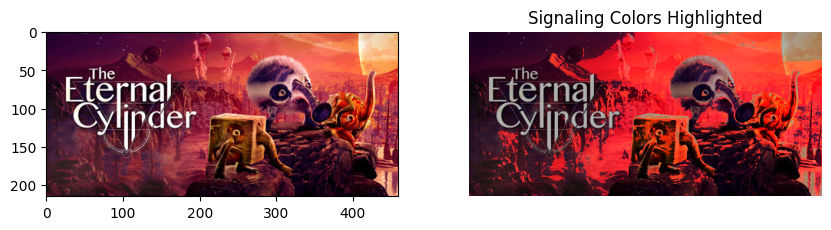

In [14]:
def highlight_signaling_colors(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define color ranges
    red_lower1, red_upper1 = np.array([0, 120, 120]), np.array([10, 255, 255])   # Red (low end)
    red_lower2, red_upper2 = np.array([170, 120, 120]), np.array([180, 255, 255]) # Red (high end)
    yellow_lower, yellow_upper = np.array([20, 100, 100]), np.array([35, 255, 255]) # Yellow
    orange_lower, orange_upper = np.array([10, 150, 100]), np.array([20, 255, 255]) # Orange

    # Create masks for each color
    mask_red = cv2.inRange(hsv, red_lower1, red_upper1) | cv2.inRange(hsv, red_lower2, red_upper2)
    mask_yellow = cv2.inRange(hsv, yellow_lower, yellow_upper)
    mask_orange = cv2.inRange(hsv, orange_lower, orange_upper)

    # Combine masks
    mask = mask_red | mask_yellow | mask_orange

    # Convert mask to 3-channel (Red overlay)
    mask_colored = np.zeros_like(image)  # Start with a black image
    mask_colored[:, :, 0] = mask  # Assign mask to Red channel (0: Red, 1: Green, 2: Blue)

    # Overlay mask on the original image
    overlayed = cv2.addWeighted(image, 0.7, mask_colored, 0.5, 0)

    return overlayed

image = images["img"][2]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Apply the overlay function
highlighted_image = highlight_signaling_colors(image)

# Show the result
axes[0].imshow(image)
axes[1].imshow(highlighted_image)
plt.axis("off")
plt.title("Signaling Colors Highlighted")
plt.show()

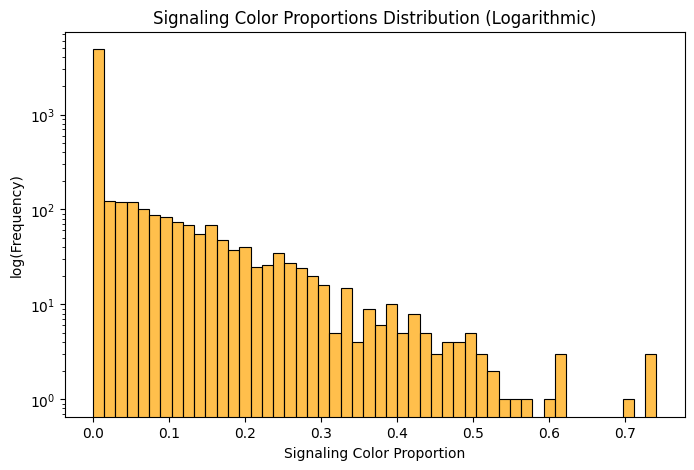

In [168]:
plt.figure(figsize=(8, 5))

sns.histplot(signaling_scores, bins=50, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("Signaling Color Proportion")
plt.ylabel("log(Frequency)")
plt.title("Signaling Color Proportions Distribution (Logarithmic)")
plt.yscale("log")

> The distribution of signaling color proportion is notable for its skew; most images are not dominated by red, orange, and yellow. It could be that the presence of signaling colors is more important than proportion though; a binary feature variable will be created for use in modeling based on thresholding.

In [191]:
images.add_column("signal_present", (signaling_scores > 0.1).astype(int))

signal_df = pd.DataFrame(
    {"signal_proportion": images.data["signal"], "signal_present": images.data["signal_present"]},
    index=images.map.keys())
signal_df.index
signal_df

signal_proportion  signal_present
1126290           0.000000               0
2643960           0.000000               0
865680            0.000000               0
22500             0.067647               0
880950            0.000000               0
...                    ...             ...
1172470           0.000000               0
1203220           0.000000               0
570               0.000000               0
578080            0.000000               0
730               0.000000               0

[6174 rows x 2 columns]

### Create DataFrames

In [200]:
# Map histogram features to RGB labels
def interpret_hist_feature(hist_index):
    channel = hist_index // 256  # 0,1,2 -> RGB
    bin_index = hist_index % 256
    channels = ["red", "green", "blue"]
    return f"{channels[channel]}_{bin_index}"

hist_flat = images["hist"].reshape(6174, -1)  # Shape becomes (6174, 768)
hist_df = pd.DataFrame(
    hist_flat, index=list(images.map.keys()),
    columns=[f"hist_{i}" for i in range(hist_flat.shape[1])])

# Convert PCA features to dataframe
pca_df = pd.DataFrame(
    images["pca"], index=list(images.map.keys()),
    columns=[f"pca_{i}" for i in range(images["pca"].shape[1])])

# Rename histogram feature columns
hist_feature_names = [interpret_hist_feature(i) for i in range(768)]
hist_df.columns = hist_feature_names

# Get projected histograms
pca_color = PCA(n_components=0.95)
hist_pca_df = pd.DataFrame(pca_color.fit_transform(hist_df), index=hist_df.index)
hist_pca_df.columns = [f"hist{i}" for i in hist_pca_df.columns]

# Concatenate color histogram, PCA features, and signaling color features
visual_features_df = pd.concat([hist_pca_df, pca_df, signal_df], axis=1)

# Normalize visual features
# scaler = StandardScaler()
# visual_features_scaled = scaler.fit_transform(visual_features_df)
# visual_features_df = pd.DataFrame(visual_features_scaled, index=visual_features_df.index, columns=visual_features_df.columns)

---

## Tags

> Tags provide finer-grained descriptions of games than genre. Here, they will be encoded for modeling later and explored for aspects such as co-occurrence and relationships to image features.

### Encoding

In [16]:
# Group tags by app_id
grouped_df = tags.groupby("app_id")["tag"].apply(list).reset_index()

# Apply MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tag_matrix = mlb.fit_transform(grouped_df["tag"])

# Convert to DataFrame
tag_df = pd.DataFrame(tag_matrix, columns=mlb.classes_, index=grouped_df["app_id"])

### Top Tag Co-Occurence

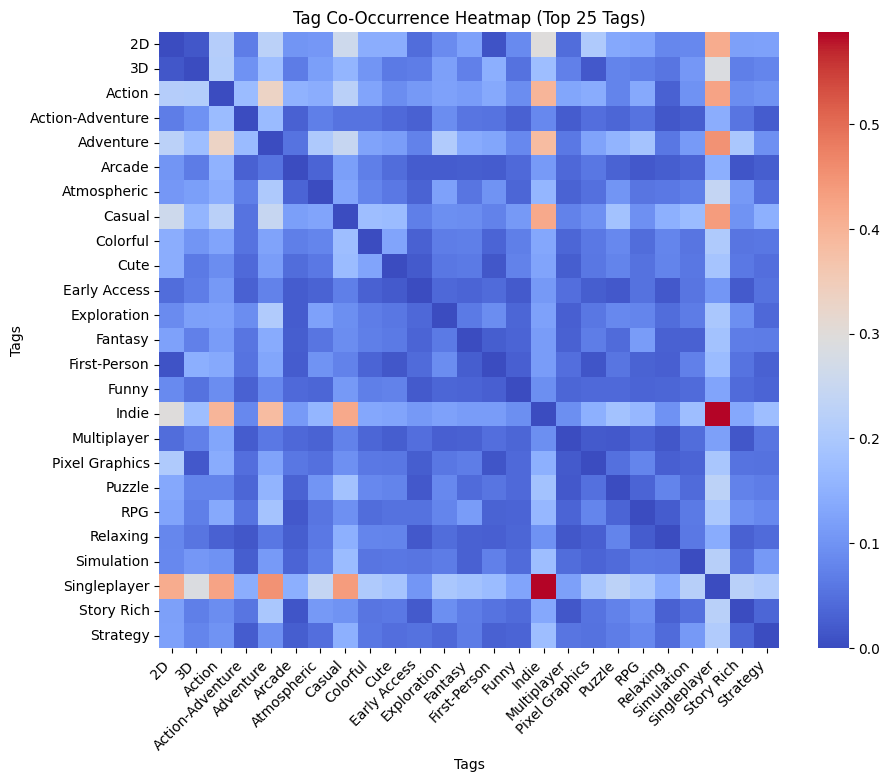

In [17]:
top_n = 25
tag_counts = tags["tag"].value_counts()
top_tags = tag_counts.nlargest(top_n).index

# Filter dataset to include only top tags
filtered_df = tags[tags["tag"].isin(top_tags)]

# Compute matrix
co_mat = pd.crosstab(filtered_df["app_id"], filtered_df["tag"])
co_mat = co_mat.T.dot(co_mat)

# Normalize
co_mat = co_mat / co_mat.max().max()

# Zero out diagonal
np.fill_diagonal(co_mat.values, 0.0)

plt.figure(figsize=(10, 8))
sns.heatmap(co_mat, cmap="coolwarm", annot=False, xticklabels=True, yticklabels=True)
plt.title("Tag Co-Occurrence Heatmap (Top {} Tags)".format(top_n))
plt.xlabel("Tags")
plt.ylabel("Tags")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

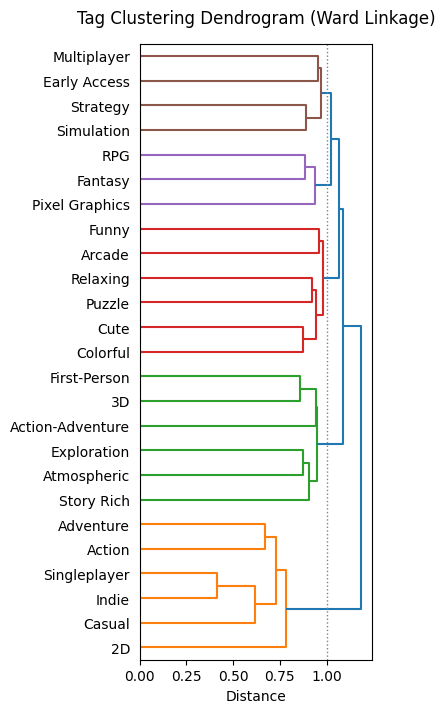

In [18]:
# Convert similarity to distance
distance_matrix = 1 - co_mat

# Convert to condensed format (required for linkage)
condensed_dist = squareform(distance_matrix, checks=False)

# Perform clustering
linkage_matrix = linkage(condensed_dist, method='ward')

plt.figure(figsize=(3, 8))
threshold = 1.0
dendrogram(linkage_matrix, labels=co_mat.index, leaf_rotation=0, orientation="right", color_threshold=threshold)
plt.axvline(threshold, color="gray", ls=":", linewidth=1)
plt.title("Tag Clustering Dendrogram (Ward Linkage)", y=1.02)
plt.xlabel("Distance")
plt.show()

### Tag Combinations

In [19]:
# Generate tag pairs
tag_pairs = []
for tags in grouped_df["tag"]:
    tag_pairs.extend(combinations(tags, 2))

# Count frequency of each tag pair
tag_pair_counts = Counter(tag_pairs)

# Convert to DataFrame
tag_pair_df = pd.DataFrame(tag_pair_counts.items(), columns=["TagPair", "Count"]).sort_values(by="Count", ascending=False)

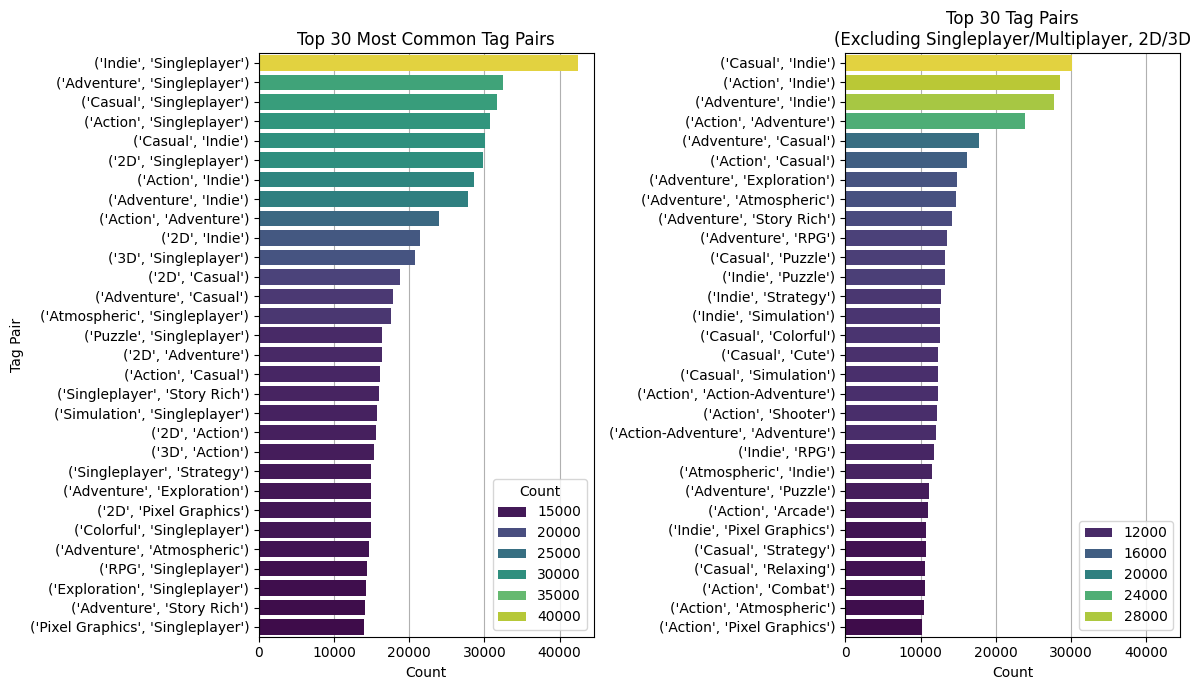

In [20]:
# Define tags to exclude
exclude_tags = {"Singleplayer", "2D", "3D", "Multiplayer"}

# Get the top 30 tag pairs
df_top = tag_pair_df.nlargest(30, "Count")
df_top["TagPair"] = df_top["TagPair"].astype(str)

# Filter out tag pairs containing excluded tags
df_filtered = tag_pair_df[~tag_pair_df["TagPair"].apply(lambda x: any(tag in x for tag in exclude_tags))]

# Ensure the filtered dataset also contains 30 entries
df_filtered_top = df_filtered.nlargest(30, "Count")
df_filtered_top["TagPair"] = df_filtered_top["TagPair"].astype(str)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharex=True)

# Plot all top tag pairs
sns.barplot(y=df_top["TagPair"], x=df_top["Count"], hue=df_top["Count"], palette="viridis", ax=axes[0])
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Tag Pair")
axes[0].set_title("Top 30 Most Common Tag Pairs")
axes[0].grid(axis="x")
axes[0].set_axisbelow(True)

# Plot filtered tag pairs (ensuring it also contains 30 entries)
sns.barplot(y=df_filtered_top["TagPair"], x=df_filtered_top["Count"],
            hue=df_filtered_top["Count"], palette="viridis", ax=axes[1])
axes[1].set_xlabel("Count")
axes[1].set_ylabel(None)
axes[1].set_title("Top 30 Tag Pairs\n(Excluding Singleplayer/Multiplayer, 2D/3D")
axes[1].grid(axis="x")
axes[1].set_axisbelow(True)
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


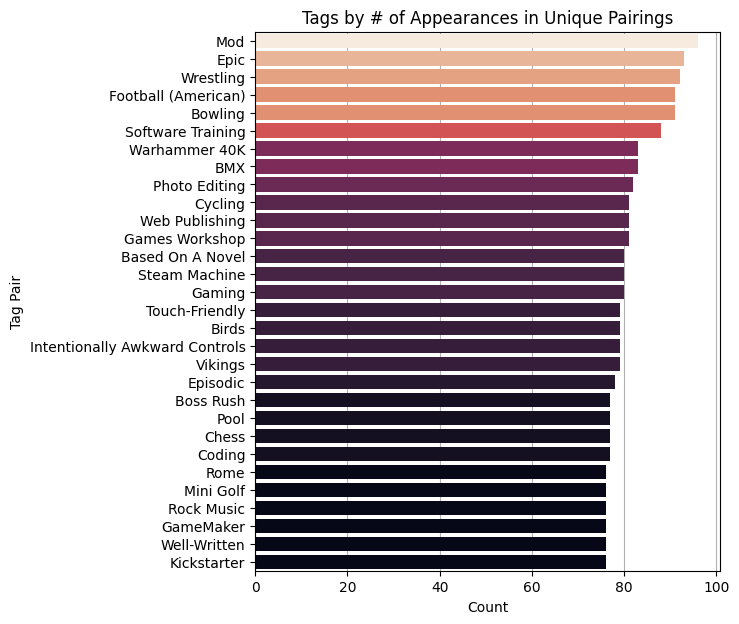

In [21]:
# Filter rare tag pairs
rare_pairs = [pair for pair, count in tag_pair_counts.items() if count <= 1]

# Extract individual tags from rare pairs
uncommon_tags = [tag for pair in rare_pairs for tag in pair]

# Count occurrences of each tag in these rare pairs
uncommon_tag_counts = Counter(uncommon_tags)

uncommon_tag_df = pd.DataFrame(
    uncommon_tag_counts.items(),
    columns=["Tag", "Count"]).sort_values(by="Count", ascending=False)

df = uncommon_tag_df.nlargest(30, "Count")

plt.figure(figsize=(6, 7))
sns.barplot(y=df["Tag"], x=df["Count"], hue=df["Count"], palette="rocket", legend=False)
plt.xlabel("Count")
plt.ylabel("Tag Pair")
plt.title("Tags by # of Appearances in Unique Pairings")
plt.gca().set_axisbelow(True)
plt.grid(axis="x")
plt.show()

### Relationship to Image Features

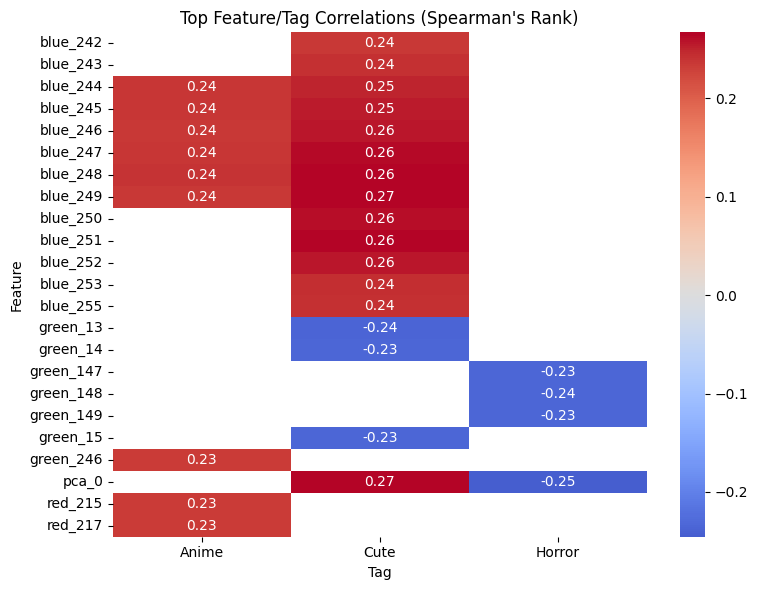

In [95]:
# Count how many games have each tag and keep only frequent
min_games = 50
tag_counts = tag_df.sum()
common_tags = tag_counts[tag_counts >= min_games].index

# Filter tag matrix to only include common tags
filtered_tag_df = tag_df[common_tags]

# Compute correlation matrix again with meaningful labels
combined_df = filtered_tag_df.merge(hist_df, left_index=True, right_index=True).merge(pca_df, left_index=True, right_index=True)
correlation_matrix = combined_df.corr("spearman")

# Extract correlations of tags with image features
tag_image_corr = correlation_matrix.loc[filtered_tag_df.columns, hist_feature_names + list(pca_df.columns)]

# Show top readable correlations
top_tag_correlations = tag_image_corr.unstack().sort_values(key=abs, ascending=False).head(30)

df = top_tag_correlations.rename_axis(['Feature', 'Tag']).reset_index(name='Corr')
pivot = df.pivot(index="Feature", columns="Tag", values="Corr")

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap="coolwarm", center=0)
plt.title("Top Feature/Tag Correlations (Spearman's Rank)")
plt.tight_layout()
plt.show()

> Looking at correlations between colors and tags, it seems that images with high blue values seem to correspond seem to be relatiely commonplace among games tagged as 'Anime' and 'Cute'. Additionally, the first pricinipal component seems to have some utility at differentiated between 'Cute' and 'Horror' games. However, that the highest correlations hover around 0.25 suggests that tags and images aren't reliably related in a way that is all that significant. This can be further seen by looking at the distribution.

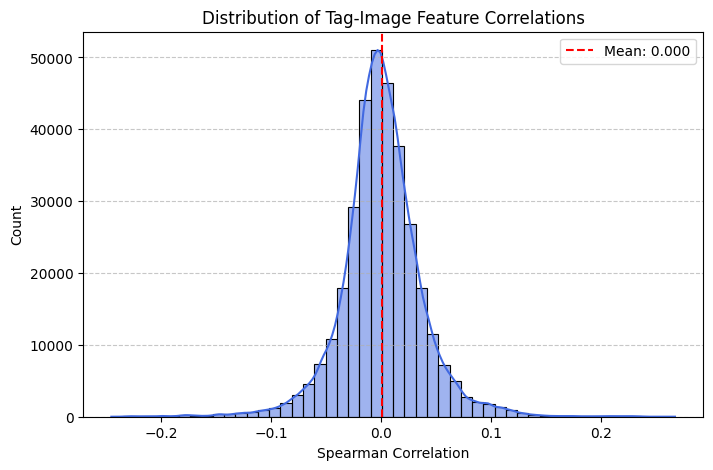

In [23]:
# Flatten correlation values into a list for distribution analysis
corr_values = tag_image_corr.values.flatten()

corr_values = corr_values[~pd.isna(corr_values)]

plt.figure(figsize=(8, 5))
sns.histplot(corr_values, bins=50, kde=True, color="royalblue")
plt.xlabel("Spearman Correlation")
plt.ylabel("Count")
plt.title("Distribution of Tag-Image Feature Correlations")
plt.axvline(x=corr_values.mean(), color="red", linestyle="dashed", label=f"Mean: {corr_values.mean():.3f}")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

> The distribution of correlations is a rather unremarkable standard distribution; the magnitudes are low and the mean is practically zero.

---

## Titles and Descriptions

> To make some use of titles and descriptions, embeddings can be created. There are many options here, but simplicity

### Embedding (w/ Sentence Transformers, ie SBERT)

In [24]:
top_games = top_ids.merge(games, how="left", on="app_id")
top_desc = top_ids.merge(desc, how="left", on="app_id")

In [25]:
# Load model
# model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device="cpu")
model = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2", device="cpu")

# Encode text
title_emb = model.encode(top_games.name, device="cpu")
desc_emb = model.encode(top_desc.summary, device="cpu")

In [26]:
# Create column names
title_columns = [f"title_{i}" for i in range(384)]
description_columns = [f"description_{i}" for i in range(384)]

embedding_df = pd.DataFrame(
    np.hstack((title_emb, desc_emb)),
    index=top_games.app_id,
    columns=title_columns + description_columns 
)
embedding_df = embedding_df.reset_index()
embedding_df

app_id   title_0   title_1   title_2   title_3   title_4   title_5  \
0     1126290 -0.039796 -0.066648 -0.019339  0.007776  0.004680  0.036229   
1     2643960 -0.052293 -0.070472 -0.038401  0.030274  0.043497  0.039690   
2      865680 -0.063808  0.090013 -0.047367  0.018288 -0.046687 -0.072908   
3       22500 -0.048984  0.042320 -0.033009 -0.027639  0.084869  0.011338   
4      880950 -0.025306 -0.006375 -0.060731  0.071660  0.028178 -0.004642   
...       ...       ...       ...       ...       ...       ...       ...   
6169  1172470 -0.047691  0.007394 -0.067488 -0.072602  0.023717 -0.017290   
6170  1203220 -0.054417  0.037796 -0.093334  0.021946 -0.021290  0.018050   
6171      570 -0.070571 -0.007154 -0.047922 -0.065424  0.011114 -0.009165   
6172   578080 -0.074491 -0.015136  0.048813 -0.032597  0.002164 -0.008741   
6173      730 -0.108464  0.006045 -0.097539 -0.024448  0.003061  0.021726   

       title_6   title_7   title_8  ...  description_374  description_375  \
0     0.073831  0.059800  0.051987  ...         0.043425        -0.014845   
1    -0.012616  0.066850  0.009241  ...        -0.013525         0.057988   
2     0.058743  0.079287  0.052643  ...         0.099089        -0.048456   
3     0.067828  0.042780 -0.016633  ...         0.036016         0.010024   
4    -0.063751  0.050874 -0.064398  ...        -0.013239        -0.061991   
...        ...       ...       ...  ...              ...              ...   
6169  0.005622 -0.013967 -0.014971  ...         0.038052         0.008257   
6170 -0.014831  0.029253 -0.010694  ...        -0.007954         0.059067   
6171  0.008586 -0.016235 -0.028098  ...         0.048568         0.078311   
6172  0.031881 -0.024350  0.000962  ...         0.042866         0.078852   
6173  0.089267  0.050169  0.014106  ...         0.040873         0.060497   

      description_376  description_377  description_378  description_379  \
0            0.022096        -0.017911         0.018702         0.078043   
1            0.026569         0.099942        -0.025452         0.022758   
2           -0.063323        -0.000794         0.011083         0.025473   
3            0.015190         0.030427         0.012643        -0.036009   
4           -0.090357         0.077156         0.011795         0.044500   
...               ...              ...              ...              ...   
6169         0.062589         0.085809        -0.101313        -0.049989   
6170        -0.026197        -0.033046        -0.026581         0.052657   
6171         0.129888         0.120189        -0.011911        -0.015225   
6172        -0.013378         0.122773         0.058950        -0.013614   
6173         0.067719         0.004917        -0.060449        -0.017655   

      description_380  description_381  description_382  description_383  
0            0.018789         0.058836        -0.054500        -0.020064  
1            0.093555        -0.051189        -0.004365         0.080335  
2            0.015543         0.043766         0.032030        -0.010206  
3           -0.026378        -0.081502         0.003229         0.017836  
4            0.126187         0.011557         0.046106         0.029332  
...               ...              ...              ...              ...  
6169         0.054152        -0.036878         0.002164         0.006491  
6170         0.110720        -0.076734        -0.093731         0.058888  
6171         0.005756        -0.008738        -0.061537        -0.054621  
6172        -0.083777         0.002933        -0.009974         0.011236  
6173         0.013864         0.029737        -0.083532        -0.004351  

[6174 rows x 769 columns]

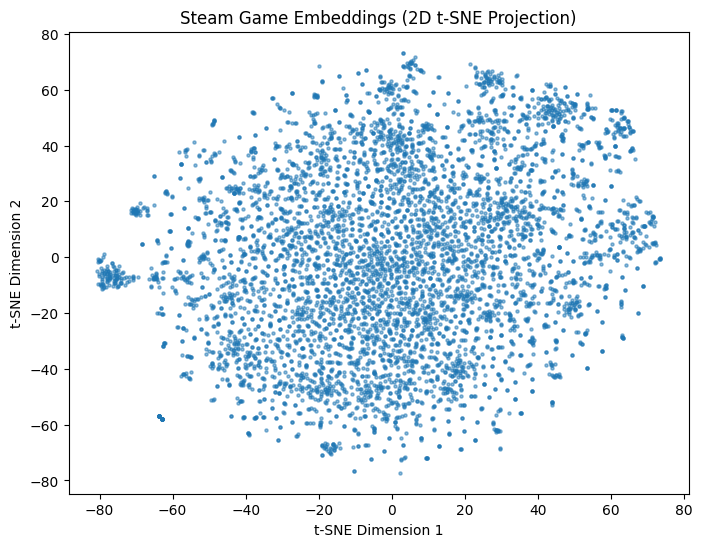

In [27]:
reducer = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = reducer.fit_transform(desc_emb)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=5, alpha=0.5)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("Steam Game Embeddings (2D t-SNE Projection)")
plt.show()

### Correlation with Image Features

In [109]:
# Canonical correlation (corr between projections of visual features and description embeddings)
cca = CCA(n_components=1)
X_c, Y_c = cca.fit_transform(visual_features_df.values, desc_emb)
corr = np.corrcoef(X_c.T, Y_c.T)[0, 1]
print(f"CCA correlation: {corr:.3f}")

CCA correlation: 0.515


> There seems to be moderate correlation between image features and description embeddings. This is interesting, but also hints at some possible redundancy if modeling with both as predictors.

---

## Game Metadata

#### Wrangling and Cleaning

***Dates***

In [110]:
games_df = games

games_df["release_date"] = pd.to_datetime(games_df["release_date"], errors="coerce")
games_df["date_missing"] = games_df["release_date"].isna().astype(int)

games_df["release_year"] = games_df["release_date"].dt.year.fillna(-1).astype(int)
games_df["release_month"] = games_df["release_date"].dt.month.fillna(-1).astype(int)
games_df["release_day"] = games_df["release_date"].dt.day.fillna(-1).astype(int)

***Price (Convert to Euros)***

In [111]:
# Safe regex extraction function
def extract_price_currency(price_str, is_free):
    if is_free == 1 or pd.isna(price_str):
        return 0.0, "FREE"
    
    price_match = re.search(r"'final':\s*(\d+)", price_str)
    currency_match = re.search(r"'currency':\s*'(\w+)'", price_str)

    price = int(price_match.group(1)) / 100 if price_match else 0.0  # Convert cents to float
    currency = currency_match.group(1) if currency_match else "UNKNOWN"

    return price, currency

# Apply function to extract price and currency
games_df[['price', 'currency']] = games_df.apply(
    lambda row: pd.Series(extract_price_currency(row["price_overview"], row["is_free"])), axis=1)

# October 2024
EXCHANGE_RATES = {
    "USD": 1/1.0882,  # https://eur-lex.europa.eu/legal-content/EN/TXT/PDF/?uri=OJ:C_202405911
    "GBP": 1/0.83753, # https://eur-lex.europa.eu/legal-content/EN/TXT/PDF/?uri=OJ:C_202405911
    "RUB": 0.009545   # https://www.x-rates.com/average/?from=RUB&to=EUR&amount=1&year=2024
}

def convert_price(row):
    if row["currency"] == "FREE":
        return 0.0
    elif row["currency"] in EXCHANGE_RATES:
        return row["price"] * EXCHANGE_RATES[row["currency"]]
    return row["price"]  # Keep EUR prices unchanged

# Apply conversion
games_df["price_euros"] = games_df.apply(convert_price, axis=1)

# Filter dataset to keep only EUR, FREE, and converted currencies
valid_currencies = {"EUR", "FREE"}
games_df = games_df[games_df["currency"].isin(valid_currencies | set(EXCHANGE_RATES.keys()))]

games_df = games_df.drop(columns=["currency", "price"])

---

## Concurrent Users

> To see if these selected and derived features are indicative (or at least related) to a game's success, some visualizations and attempts at modeling the number of concurrent users is included. As a note, the focus on this metric stems from limitations with another; while the SteamSpy portion of the dataset does offer an estimated number of owners, these are very coarsely binned and possibly less relevant at present due to the inclusion of many older games.

### Distribution

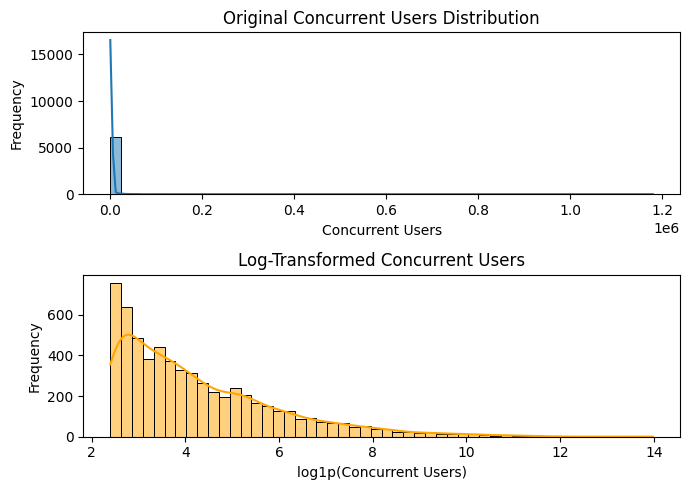

In [148]:
y = top_ids.merge(spy, on="app_id")["concurrent_users_yesterday"]

fig, axes = plt.subplots(2, 1, figsize=(7, 5))

# Original scale
sns.histplot(y, bins=50, kde=True, ax=axes[0])
axes[0].set_title("Original Concurrent Users Distribution")
axes[0].set_xlabel("Concurrent Users")
axes[0].set_ylabel("Frequency")

# Log-transformed
sns.histplot(np.log1p(y), bins=50, kde=True, color="orange", ax=axes[1])
axes[1].set_title("Log-Transformed Concurrent Users")
axes[1].set_xlabel("log1p(Concurrent Users)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

> The distribution of concurrent users is highly skewed; a small proportion of games get a high proportion of players. Modeling will likely benefit from log transformation.

### Relationship to Image Features

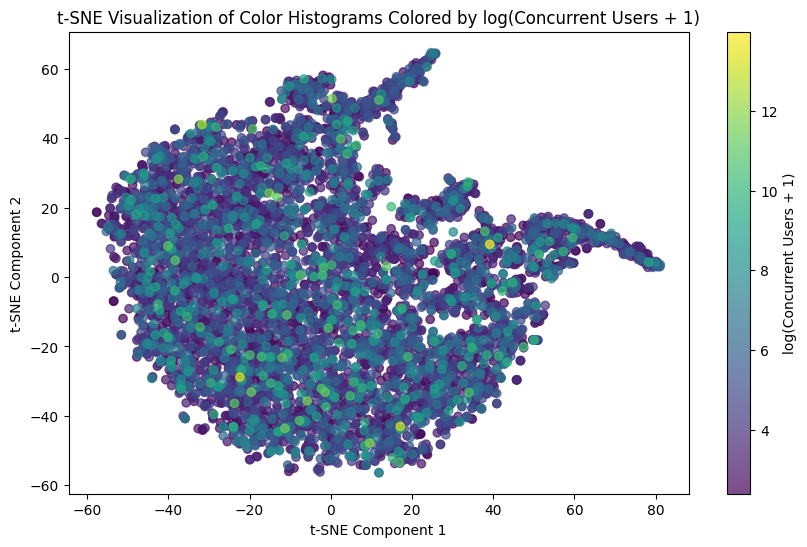

In [33]:
def plot_histogram_tsne_users(user_counts):
    """t-SNE visualization of color histograms with color mapping based user count"""
    hist_vectors = []
    user_values = []

    for app_id in images.map.keys():
        hist = images.get("hist", app_id).flatten()  # Flatten histogram vector
        
        if app_id in user_counts:
            hist_vectors.append(hist)
            user_values.append(user_counts[app_id])

    hist_vectors = np.array(hist_vectors)
    user_values = np.array(user_values)

    # Reduce to 2D using t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings = tsne.fit_transform(hist_vectors)

    df = pd.DataFrame({
        "x": embeddings[:, 0],
        "y": embeddings[:, 1],
        "users": user_values,
    })

    # Scatter plot with color gradient based on users
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df["x"], df["y"], c=df["users"], cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label="log(Concurrent Users + 1)")
    plt.title("t-SNE Visualization of Color Histograms Colored by log(Concurrent Users + 1)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

# Convert log user counts to a dictionary
user_counts = spy.groupby("app_id")["concurrent_users_yesterday"].apply(lambda x: np.log1p(x).iloc[0]).to_dict()

plot_histogram_tsne_users(user_counts)

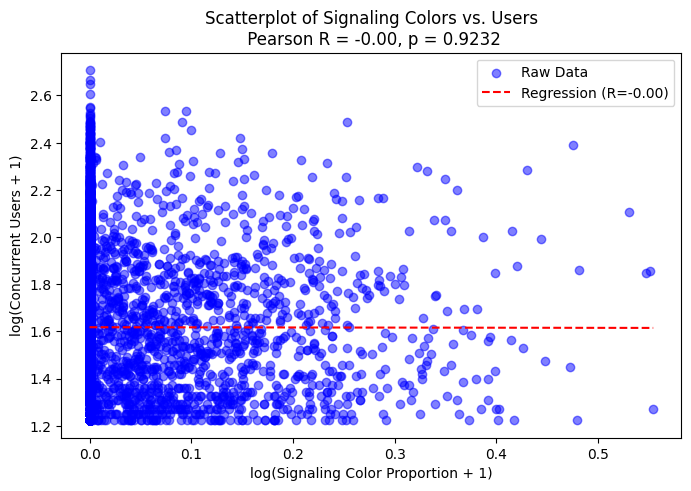

In [34]:
user_values = np.array([user_counts.get(app_id, 0) for app_id in images.map.keys()])  # Match order

df = pd.DataFrame({"signaling": signaling_scores, "log_signaling": np.log1p(signaling_scores),
                   "log_users": np.log1p(user_values)})

# Compute regression 
slope_raw, intercept_raw, r_value_raw, p_value_raw, std_err_raw = linregress(df["log_signaling"], df["log_users"])
x_range = np.linspace(df["log_signaling"].min(), df["log_signaling"].max(), 100)
y_fit_raw = slope_raw * x_range + intercept_raw

# Compute Pearson correlation
pearson_corr, pearson_p = pearsonr(df["log_signaling"], df["log_users"])

plt.figure(figsize=(8, 5))
plt.scatter(df["log_signaling"], df["log_users"], alpha=0.5, color="blue", label="Raw Data")
plt.plot(x_range, y_fit_raw, color="red", linestyle="--", label=f"Regression (R={r_value_raw:.2f})")
plt.xlabel("log(Signaling Color Proportion + 1)")
plt.ylabel("log(Concurrent Users + 1)")
plt.title(f"Scatterplot of Signaling Colors vs. Users\n Pearson R = {pearson_corr:.2f}, p = {pearson_p:.4f}")
plt.legend()
plt.show()

> Based on these plots, there doesn't appear to be evidence that either color histograms or signaling color proportions are meaningfully connected to concurrent users.

### Prediction

> Along with the generally high dimensionality of the data, the lack of a clear relationship between image features and concurrent users indicates the usefulness of a feature selection efforts. After experimenting, gradient boosting models provided the best results. To offset their relative lack of explainability, Shapley Additive Explanations (SHAP) values have been computed and displayed.

***Prepare Data***

In [246]:
features = ["app_id", "price_euros", "date_missing", "release_year", "release_month", "release_day"]

pred_df = top_ids.merge(games_df, how="left", on="app_id")

pred_df = pred_df.loc[:, features]

pred_df = spy.loc[:, ["app_id", "concurrent_users_yesterday"]].merge(pred_df, on="app_id", how="right")

pred_df = pred_df.merge(visual_features_df.reset_index().rename({"index": "app_id"}, axis=1),
              how="left", on="app_id")
pred_df = pred_df.merge(embedding_df, how="left", on="app_id")
pred_df = pred_df.merge(tag_df, how="left", on="app_id")

pred_df = pred_df.dropna()

In [247]:
X = pred_df.drop(columns=["concurrent_users_yesterday"])
X = X.drop(columns=["app_id"])
X_features = X.columns.copy()

y = pred_df["concurrent_users_yesterday"]

***Preprocessing***

In [248]:
# Initial feature selection =================

# Remove features with near-zero variance
vt = VarianceThreshold(threshold=0.01)
X = vt.fit_transform(X)
vt_feature_names = X_features[vt.get_support()]

def remove_correlated_features(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)
X = pd.DataFrame(X, columns=vt_feature_names)
X = remove_correlated_features(X)
corr_feature_names = X.columns.copy()

# Split ======================================

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# More feature selection =====================

# Perform feature seleciton with lasso CV
# lasso = ElasticNetCV(cv=5, alphas=np.logspace(-4, 1, 50), max_iter=10_000).fit(X_train, y_train)
# selected_features = X.columns[lasso.coef_ != 0]
# print(selected_features)
# X_train = X_train[:, lasso.coef_ != 0]
# X_test = X_test[:, lasso.coef_ != 0]

# Select top most informative features (via mutual info regression)
k = 200
selector = SelectKBest(mutual_info_regression, k=k)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)
selected_feature_names = corr_feature_names[selector.get_support()]

# Scaling ====================================

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Target Log transform =======================

# Concurrent users is highly skewed, apply log transform
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

***Modeling and Evaluation***

In [249]:
reg = lgb.LGBMRegressor(
    # n_estimators=500,
    # max_depth=6,
    # num_leaves=31,
    # subsample=0.8,
    # colsample_bytree=0.8,
    random_state=42
)
reg.fit(X_train, y_train_log)

# Predict on test set
y_pred_log = reg.predict(X_test)
y_pred = np.expm1(y_pred_log) # Convert to normal scale

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4713
[LightGBM] [Info] Number of data points in the train set: 4706, number of used features: 200
[LightGBM] [Info] Start training from score 4.255287


c:\Users\eric\Documents\A_OREGON\25_winter\cs670_datascience\project\cs670_project\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE: 1221.7240
RMSE: 15394.3245
R-Squared: 0.0005


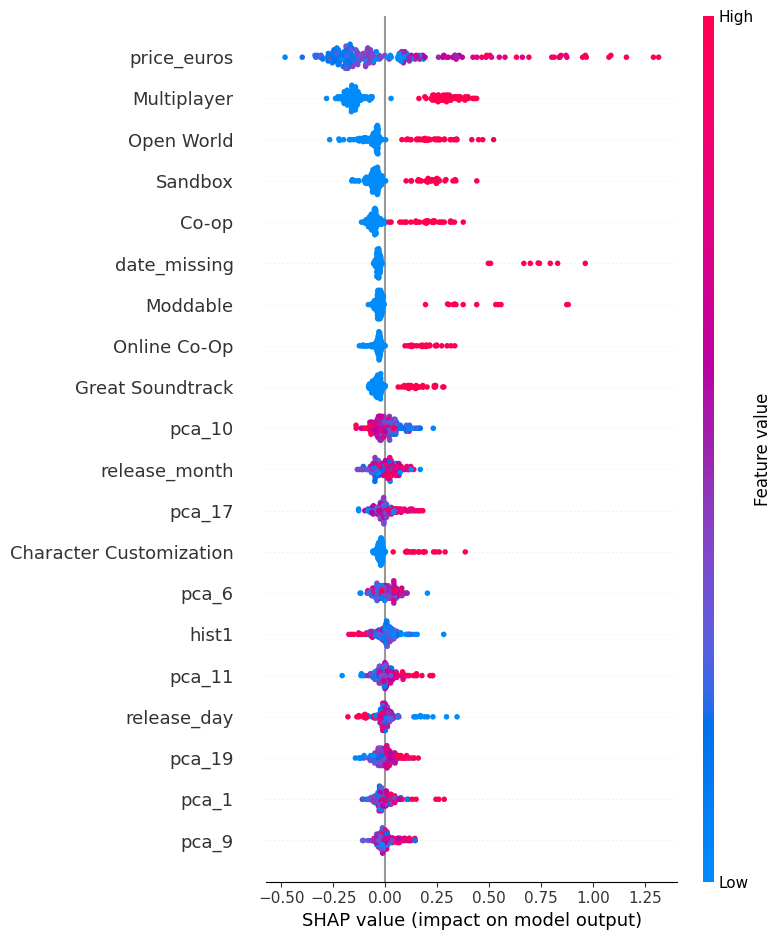

In [250]:
# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-Squared: {r2:.4f}")

shap_n = 200 # Sample size
df = pd.DataFrame(X_test[:shap_n], columns=selected_feature_names)

explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(df)
shap.summary_plot(shap_values, df)

> After much tuning and tinkering with different preprocessing approaches, the model afforded R^2 values of approximately 0; inclusion of various features offered no better results than a trivial model. The SHAP values indicate price, tags such as multiplayer, and structural image features would be more useful than others, but this means little given the weakness of the model. To summarize, the following methods were tested:

* Models
    * Support vector machines (SVR)
    * Random forest
    * Gradient boosting (LightGBM)
* Feature selection
    * Lasso
    * ElasticNet
    * Selection based on mutual info regression
    * Variance thresholding
    * Correlation thresholding
* Preprocessing
    * Standard scaling (for SVM)
    * Target log transform
* Explainability
    * SVM coefficient magnitudes
    * Permutation importance
    * SHAP values

> While not exhaustive, this search indicates that these features are not quite enough for a meaningful result. Realistically, the number of concurrent users for this particular snapshot in time would likely be elucidated by time series data, information about social media presence, economic context, and plenty more not included in this dataset. Still, a more exhaustive search and extensive processing of multimodal data could afford the surprising relationships I was originally hoping to stumble upon. In lieu of that, let's try a simple model with some of the more promising features.

In [258]:
# Define features and target
X = pred_df.loc[:, ["price_euros", "Great Soundtrack", "Indie", "pca_2", "release_day"]]
y = pred_df["concurrent_users_yesterday"]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE       :", mse)
print("R-Squared :", r2)
print("\nCoefficients")
# Show coefficients with feature names
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")

MSE       : 235545317.29777363
R-Squared : 0.006622503954164527

Coefficients
price_euros: -14.6483
Great Soundtrack: -403.1176
Indie: -994.5817
pca_2: -0.0296
release_day: -91.3692


> A simple linear regression model affords similarly poor results and little may be gleaned from the coefficients here as a result. The supposed relevance of release day of the month and negative impact of Great Soundtrack is surprising insofar as one would be willing to ignore this.

---

## Review Scores

> Another metric of a games success is its review scores. In this case, this refers to aggregated review scores from users on the Steam platform itself. User reviews certainly differ from critic reviews, and there are many interesting questions that could be explored when armed with user review text as well. That said, this section is more modestly scoped; this particular dataset doesn't include this information and this will be a simpler effort at prediction to mirror the concurrent user exploration.

### Distribution

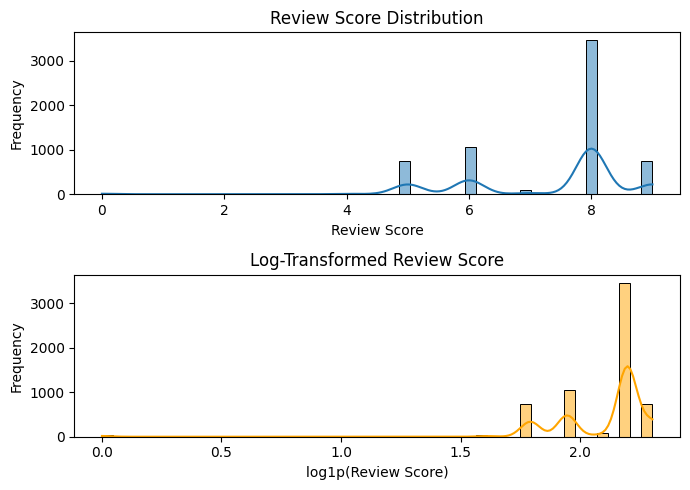

In [152]:
y = top_ids.merge(reviews, on="app_id")["review_score"]

fig, axes = plt.subplots(2, 1, figsize=(7, 5))

# Original scale
sns.histplot(y, bins=50, kde=True, ax=axes[0])
axes[0].set_title("Review Score Distribution")
axes[0].set_xlabel("Review Score")
axes[0].set_ylabel("Frequency")

# Log-transformed
sns.histplot(np.log1p(y), bins=50, kde=True, color="orange", ax=axes[1])
axes[1].set_title("Log-Transformed Review Score")
axes[1].set_xlabel("log1p(Review Score)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

> This distribution isn't skewed in the same way concurrent users is, but it is skewed toward generally positive scores. A large spike is observed around 8 and smaller spikes are seen for scores of 5 and 6.

### Prediction

***Prepare Data***

In [225]:
reviews_df = top_ids.merge(reviews, on="app_id", how="left")

# Filter out games without enough reviews for a score
reviews_df = reviews_df[reviews_df["total"] >= 10.0]

reviews_df = reviews_df.loc[:, ["app_id", "review_score"]]

# ==================================

features = ["app_id", "price_euros", "date_missing", "release_year", "release_month", "release_day"]

pred_df = top_ids.merge(games_df.loc[:, features], how="left", on="app_id")

pred_df = reviews_df.merge(pred_df, on="app_id", how="right")

# Add image, text, and tag features
pred_df = pred_df.merge(visual_features_df.reset_index().rename({"index": "app_id"}, axis=1),
              how="left", on="app_id")
pred_df = pred_df.merge(embedding_df, how="left", on="app_id")
pred_df = pred_df.merge(tag_df, how="left", on="app_id")

pred_df = pred_df.dropna()

app_id  review_score  price_euros  date_missing  release_year  \
0     1126290           8.0         2.99           0.0        2019.0   
1     2643960           7.0         4.99           0.0        2024.0   
2      865680           8.0         7.49           0.0        2022.0   
3       22500           8.0         3.44           0.0        2009.0   
4      880950           9.0        20.99           0.0        2018.0   
...       ...           ...          ...           ...           ...   
6169  1172470           5.0         0.00           1.0          -1.0   
6170  1203220           6.0         0.00           1.0          -1.0   
6171      570           8.0         0.00           1.0          -1.0   
6172   578080           5.0         0.00           0.0        2017.0   
6173      730           8.0         0.00           1.0          -1.0   

      release_month  release_day     hist0     hist1     hist2  ...  \
0               9.0         30.0 -0.083628 -0.015942  0.054089  ...   
1               6.0         21.0 -0.056565  0.019177  0.024504  ...   
2              10.0         13.0 -0.024709 -0.043779 -0.020833  ...   
3               2.0         11.0 -0.080897 -0.049672  0.083587  ...   
4               9.0         21.0 -0.086628  0.127941  0.059273  ...   
...             ...          ...       ...       ...       ...  ...   
6169           -1.0         -1.0 -0.077431  0.010601  0.053799  ...   
6170           -1.0         -1.0 -0.055455  0.004114  0.089125  ...   
6171           -1.0         -1.0 -0.075339 -0.073871 -0.069003  ...   
6172           12.0         21.0 -0.070417 -0.055075  0.013094  ...   
6173           -1.0         -1.0  0.184950 -0.043535 -0.003203  ...   

      Well-Written  Werewolves  Western  Wholesome  Word Game  World War I  \
0              0.0         0.0      0.0        0.0        0.0          0.0   
1              0.0         0.0      0.0        0.0        0.0          0.0   
2              0.0         0.0      0.0        0.0        0.0          0.0   
3              0.0         0.0      0.0        0.0        0.0          0.0   
4              0.0         0.0      0.0        0.0        0.0          0.0   
...            ...         ...      ...        ...        ...          ...   
6169           0.0         0.0      0.0        0.0        0.0          0.0   
6170           0.0         0.0      0.0        0.0        0.0          0.0   
6171           0.0         0.0      0.0        0.0        0.0          0.0   
6172           0.0         0.0      0.0        0.0        0.0          0.0   
6173           0.0         0.0      0.0        0.0        0.0          0.0   

      World War II  Wrestling  Zombies  eSports  
0              0.0        0.0      0.0      0.0  
1              0.0        0.0      0.0      0.0  
2              0.0        0.0      0.0      0.0  
3              0.0        0.0      0.0      0.0  
4              1.0        0.0      0.0      0.0  
...            ...        ...      ...      ...  
6169           0.0        0.0      0.0      0.0  
6170           0.0        0.0      0.0      0.0  
6171           0.0        0.0      0.0      1.0  
6172           0.0        0.0      0.0      0.0  
6173           0.0        0.0      0.0      1.0  

[5878 rows x 1407 columns]

In [238]:
X = pred_df.drop(columns=["review_score"])
X = X.drop(columns=["app_id"])
X_features = X.columns

y = pred_df["review_score"]

***Preprocessing***

In [239]:
# Initial feature selection =================

# Remove features with near-zero variance
vt = VarianceThreshold(threshold=0.01)
X = vt.fit_transform(X)
vt_feature_names = X_features[vt.get_support()]

X = pd.DataFrame(X, columns=vt_feature_names)
X = remove_correlated_features(X)
corr_feature_names = X.columns.copy()

# Split ======================================

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# More feature selection =====================

# Select top most informative features (via mutual info regression)
k = 200
selector = SelectKBest(mutual_info_regression, k=k)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)
selected_feature_names = corr_feature_names[selector.get_support()]

***Modeling and Evaluation***

In [240]:
reg = lgb.LGBMRegressor(
    # n_estimators=500,
    # max_depth=6,
    # num_leaves=31,
    # subsample=0.8,
    # colsample_bytree=0.8,
    random_state=42
)
reg.fit(X_train, y_train)

# Predict on test set
y_pred = reg.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3945
[LightGBM] [Info] Number of data points in the train set: 4702, number of used features: 200
[LightGBM] [Info] Start training from score 7.364313


c:\Users\eric\Documents\A_OREGON\25_winter\cs670_datascience\project\cs670_project\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE: 0.9247
RMSE: 1.1478
R-Squared: 0.1960


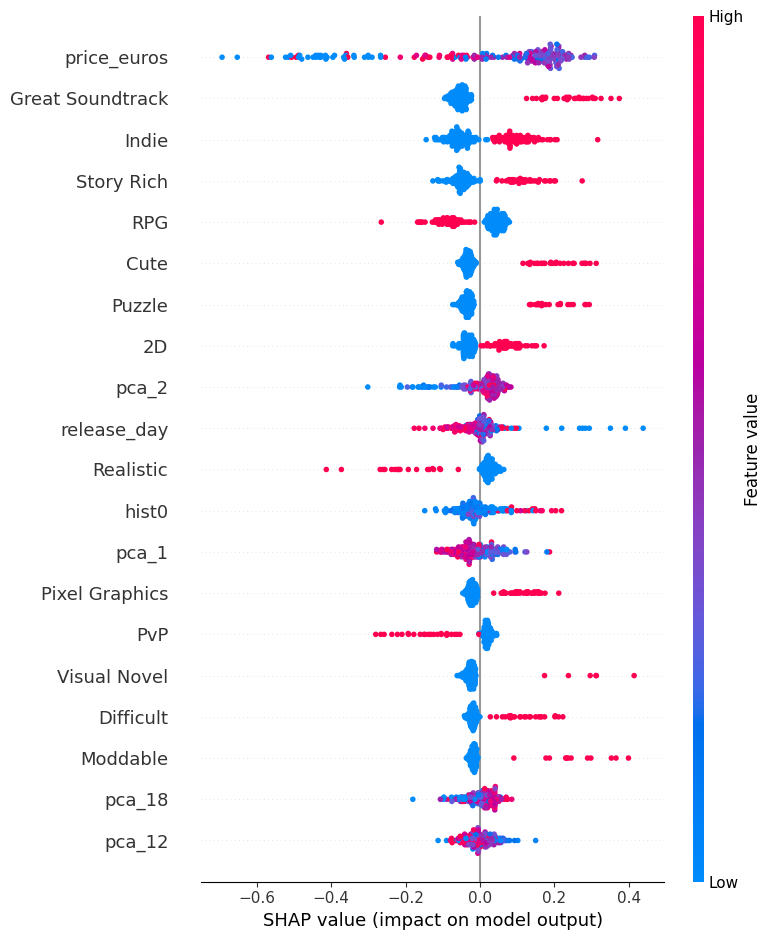

In [242]:
# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-Squared: {r2:.4f}")

shap_n = 200 # Sample size
df = pd.DataFrame(X_test[:shap_n], columns=selected_feature_names)

explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(df)
shap.summary_plot(shap_values, df)

> This model affords marginally better results than the concurrent user predictions, but with an R-squared of slightly under 0.2 the model is still nothing special. Given the distribution of review scores, any model that generally predicts about a 7 or 8 could do similarly well. It is somewhat notable that the SHAP values indicate that the model deemed some features similarly important when predicting review score as when predicting concurrent user counts. Price is unsurprising in this regard, but there is indication that games with some of the tags in this plot and with header images including some of the structural patterns found via PCA are more important than others.

---

## Discussion

The results of modeling concurrent user counts and review scores with the derived features proved disappointing, but there are a few possible explanations that indicate where one should look instead to better predict such metrics.

As mentioned, modeling would likely benefit greatly from time series data as well as greater context ranging from details about the frequency and magnitude of sales to broad economic and geopolitical context. This is not to mention the lack of direct information about gameplay, publishers, or other details that could make this sort of exploration more fruitful.

However, questions about surprising and hidden relationships between metrics of success and multimodal data being experimented with here could be answered with a deeper dive into image processing and NLP; the lack of results could just indicate the necessity of digging further into textual data like user reviews or promotional materials. Additionally, further efforts to mitigate the limitations discussed earlier could help. For a start, working with more games despite lower recent concurrent user counts could help with review scores in particular.

Regarding the impact of such models (especially more successful ones), there are questions about their utility and longevity. On one hand, if certain ways of structuring promotional material or emphasizing certain features/genres were reliably found to influence success, game development and marketing could very well be pushed in directions indicated to be more promising. This sort of exploration is clearly pursued for this reason. However, various trends, surprise successes, and surprise failures indicate the dynamism of a fundamentally creative and evolving industry.

Consequently, such questions to some degree join many others in facing the ever-present challenges inherent to moneyball. Another way to take such work is honing in on the creativity of development and tackling questions like why certain types of games pervade or how greater circumstances like COVID affect what games define the zeitgeist.